# Welcome to Workshop 3: K-Means Clustering
---

You have a large set of numeric, continuous data, with a variety of features, but no labels. You'd like to see if you can find interesting patterns in this data, but you're not sure where to start.

Enter K-Means clustering.

## Well, wait; What's clustering?

"Clustering" is finding groups of points in your data that share similar features. For example, if you were trying to divide up a city into neighborhoods, you would cluster similar houses together.

## What's "K-Means"?

Continuing the example of neighborhoods: We don't necessarily know how many neighborhoods are in our city before we try to cluster them. There could be 3, 5, 10, or 50. That's where "K" comes in - K is the number of clusters you're identifying. "Means" is simply the idea that for all K clusters, you're taking their average - their mean!

K-Means is a clustering algorithm for "unsupervised learning" - when you don't have labels for your data. If we had data for every house in a city, but no labels for neighborhoods, we would want to use K-Means.

## How do I choose K?

This is a question for which there are many answers. The simplest answer may just be, "trial and error." There are a variety of ways to do so; one being the "Elbow Method." The elbow method, while a bit advanced to implement, is quite intuitive to understand. It's a method used to visualize the best choice for K - as shown here (source: [stackoverflow](https://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means)):

![elbow-method](https://i.stack.imgur.com/BzwBY.png)

The X-axis is our choice for K, and the Y-axis is a measure of error. We can see the "elbow" point where the error sharply decreases; this is usually a good choice for K.

## How do I use it?

That's what we're about to do! However, before we dive into the programming aspects of it, let's think about the algorithm in English first.

1. Choose K random points from your data - these are your **centroids**.
2. Take the first point from your dataset. Find the centroid it is closest to, and assign it to that "cluster."
3. Update the centroid's value by taking the average of all points currently belonging to that cluster.
4. Repeat for each point in your dataset.

That is one iteration of the K-Means algorithm! The algorithm can be repeated many times over to improve accuracy. Here's a helpful visual representation, thanks to [Mubaris](https://mubaris.com/2017-10-01/kmeans-clustering-in-python):

![k-means gif](https://i.imgur.com/k4XcapI.gif)

Now that we know how it works, let's return to the elbow method momentarily. As our value for K increases, so, too, does the time it takes for K-Means to complete. A downside to the algorithm is that it's not necessarily the fastest; especially when we have a huge amount of data and features, and a big K-value.

Thinking about it intuitively, the larger our value for K, the more times we'll have to iterate through our centroids when comparing them to our points. Over a large dataset, this can really start to add up. When choosing K, over a large set of data, you'll want to balance accuracy (which we can think about intuitively for this workshop) with run time.

***

Now, let's dive in!

## The essentials

Let's begin by importing all of the packages we need, as well as making some sample data to work on.

We'll import all our usual packages for data manipulation visualization, and a dataset to work with.

In [524]:
library("ggplot2")
library("iterators")
library("datasets")

We're going to use an R database called ``attitude`` which contains questionnaire results from employees. The numbers give the percent proportion of favourable responses to seven questions in each department. We'll take a quick look at the structure of the data with the ``str()`` function:

In [527]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


There are a few different measures here, however we're going to focus on the petal length and width, and try to associate them with the species. Let's create a dataset with just the Sepal Length, Sepal Width

In [288]:
data <- subset(iris, select = c("Sepal.Length","Sepal.Width"))

## Visualizing our data

Perfect. So now we know what our data looks like numerically. What about visualy? Let's plot our data to get a feel for what it looks like.

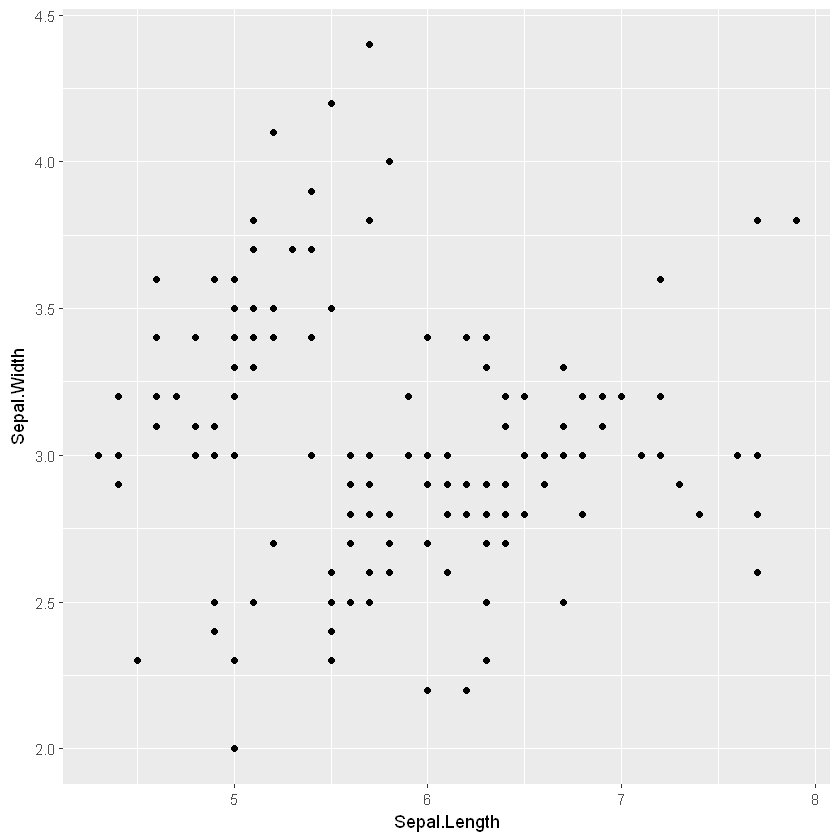

In [392]:
ggplot(data, aes(Sepal.Length, Sepal.Width)) + geom_point()

We should see some rough clusters in our datam but where does one cluster start, and the next cluster end? K-Means is going to help us answer that by showing us what the midpoints - or, centroids - of this data are.

## Analyzing our Data

Now we can get to work on our clustering. We're going to start off by randomly initializing our centroids (k-number of them). Let's write a function to implement this.

Our function will take in two arguments - a dataset, and k, the number of clusters in our data. Our function will then take our dataset and slice it. The way our function slices our dataset is by returning k-number of points, all selected randomly.

Putting that together, we now have k-number of randomly selected centroids.

In [530]:
chooseCentroids <- function(dataframe, k){
    randomSample <- dataframe[sample(nrow(dataframe),k),]
    row.names(randomSample) <- NULL
    return(randomSample)
}

centroids <- chooseCentroids(data, 3)
head(centroids)

Sepal.Length,Sepal.Width
5.6,2.9
6.8,3.0
6.1,2.9


Sometimes you'll get lucky, and your centroids will already be pretty close to the midpoints they're trying to find - this is good! It means the algorithm won't have to repeat as many times. However, if your random centroids are all bunched up or are way off, then the algorithm will have to run more times.

So let's see what this looks like. Try the following cell a bunch of times, and see how close or far your centroids randomly initialize!

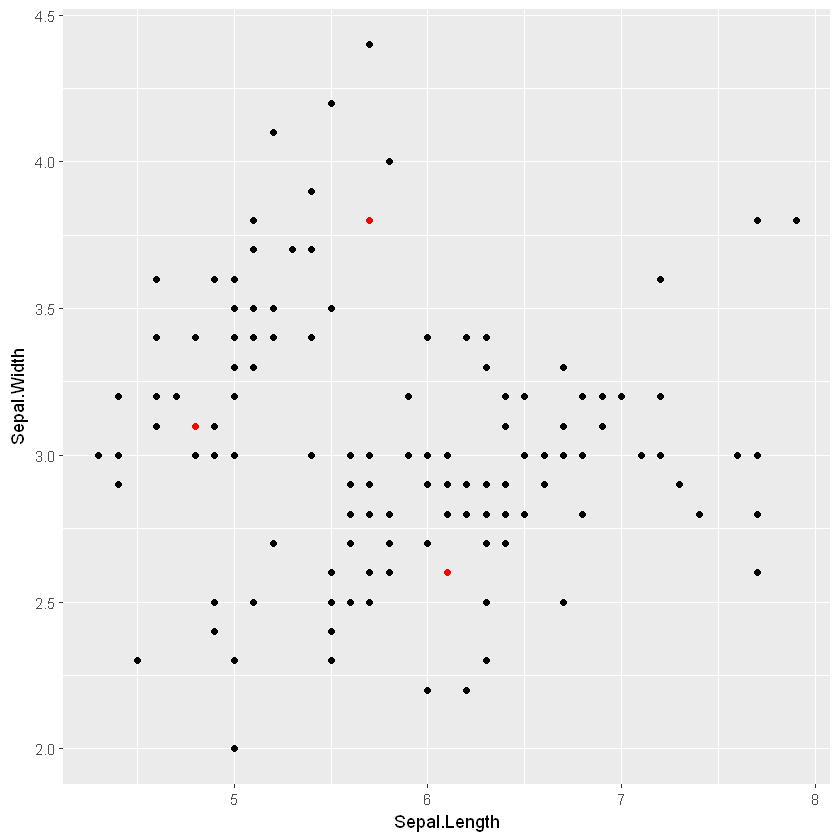

In [394]:
centroids <- chooseCentroids(data, 3)
ggplot() + geom_point(data = data, aes(Sepal.Length, Sepal.Width)) + geom_point(data = centroids, aes(Sepal.Length, Sepal.Width), color='red')

Next, we need to define how close or far our centroids are from their goal. We'll do so using Euclidean distance. We can think about Euclidean distance very similarly to the Pythagorean theorem.

In [395]:
euclideanDistance <- function(x, y, a, b){
    return(sqrt((x-a)^2+(y-b)^2))
}

The goal of the Euclidean distance is to determine how far two points are from each other on a real number plane (like our plot). In our image below, we see how we can think about our two points - (x1,y1) and (x2, y2) - being connected by a triangle. The Euclidean distance is simply the hypotenuse of this triangle - the straight line between them!

So, all we're really calculating is something a lot like the Pythagorean theorem. Credit for this image to [Rosalind.info](rosalind.info).

![Euclidean Distance](http://rosalind.info/media/Euclidean_distance.png)

Okay, now we can finally get into the actual K-Means algorithm. Fair warning, it's long - don't be intimidated! Nothing we're doing here is too complicated to understand. Let's go through this step by step, in plain English. We'll create a function, kMeans, that takes a dataset, a k value, and a maximum number of iterations as its arguments.

```R
kMeans <- function(dataframe, k, maxIterations){ ... }
```
1. We create a list to hold the history of how our centroids change, and we'll use the function we designed earlier to generate our k centroids.
```R
oldCentroids <- list()
currentCentroids <- chooseCentroids(dataframe, k)
```
2. Now we create an dataframe with a matrix to hold the values we calculate using the euclidean distance function we designed just a moment ago.
```R
distanceArray <- data.frame(matrix(ncol=k,nrow=nrow(dataframe)))
```
3. Now, we've set up the data structures we need for our algorithm, and we can begin our analysis. I recommend stopping every few steps, or wherever it feels natural, to look away from all the text and code and to simply think about what's happening in our code. 

4. Our first for loop is simply the number of times our algorithm is going to run.

```R
for(i in maxIterations){ ... }
```

5. First, let's assign our current centroids to the list of centroids. We'll do this at the beginning for every iteration in order to have a history showing how our centroids changed 

```R
oldCentroids[[j]] <- currentCentroids
```

5. Now, we're going to go through every point in our data set. For every point in our data set, we're going to calculate the Euclidean distance between our point and our current centroids. We'll then assign those distances to the data frame we constructed earlier. This dataframe will hold k columns, each containing the euclidean distance from the corresponding point to the centroid 

```R
    for(i in 1:nrow(currentCentroids)){
        point <- currentCentroids[i,]
        output <- mapply(euclideanDistance, dataframe$Sepal.Length, dataframe$Sepal.Width, point$Sepal.Length, point$Sepal.Width)
        distanceArray[i] <- output
    }
```

6. Now we're going to take this distances in our distance array and add them to our dataframw, as well as add the cluseter which that point belongs to. In our first statement, we tell R to take the smallest value in the distance array (representing the closest centroid) and add that value to the dataframe. In the next line, we run a similar command which gives us the index of the smallest value (representing the cluster number) and give that information to the dataframe as well. Our data frame now has an X point and Y point for each datapoint, the euclidean distance to the closest centroid, and the value representing what cluster the point belongs to. 

```R
    for(i in 1:nrow(distanceArray)){
        dataframe[i,3] <- distanceArray[i,which(distanceArray[i,] == min(distanceArray[i,]))]
        dataframe[i,4] <- which(distanceArray[i,] == min(distanceArray[i,]), arr.ind=TRUE)[1,2]
    }
```

7. Finally, we'll use aggregate() to gather the values of X and Y by the cluster they belong to, and find the mean for each group. We assign those values to newX and newY, and send that into a dataframe. This is the data for our new centroids (that are bo longer random, but rather, are based on the positions of the previous centroids) which we will use next iteration.

```R
    newX <- aggregate(Sepal.Length ~ V4, dataframe, mean)[2]
    newY <- aggregate(Sepal.Width ~ V4, dataframe, mean)[2]
    newCentroids <- data.frame(newX, newY)
    currentCentroids <- newCentroids
```

We did it! That's our implementation of K-Means clustering. Now, let's put it all together:

In [649]:
kMeans <- function(dataframe, k, maxIterations){

    oldCentroids <- list()
    oldDataframe <- list()
    currentCentroids <- chooseCentroids(dataframe, k)

    distanceArray <- data.frame(matrix(ncol=k,nrow=nrow(dataframe)))

    for(j in 1:maxIterations){

        # Let's generate our history by assigning our currentCentroids
        oldCentroids[[j]] <- currentCentroids

        # Calculate the euclidean distances of each x,y point
        for(i in 1:nrow(currentCentroids)){
            point <- currentCentroids[i,]
            output <- mapply(euclideanDistance, dataframe$Sepal.Length, dataframe$Sepal.Width, point$Sepal.Length, point$Sepal.Width)
            distanceArray[i] <- output
        }

        # Assign points to their closest centroids and indicate the cluster they belong to
        for(i in 1:nrow(distanceArray)){
            dataframe[i,3] <- distanceArray[i,which(distanceArray[i,] == min(distanceArray[i,]))]
            dataframe[i,4] <- which(distanceArray[i,] == min(distanceArray[i,]), arr.ind=TRUE)[1,2]
        }

        # We'll update our centroids here;
        newX <- aggregate(Sepal.Length ~ V4, dataframe, mean)[2]
        newY <- aggregate(Sepal.Width ~ V4, dataframe, mean)[2]
        newCentroids <- data.frame(newX, newY)
        currentCentroids <- newCentroids
        
        # We'll store our dataframe in the history
        oldDataframe[[j]] <- dataframe
    }
    
    return(list("dataframe"=oldDataframe, "oldCentroids"=oldCentroids))
}

## Plotting the Data

If you want to stop here, that's completely fine; that's k-Means. However, it's good practise to visualize what you're doing - both to catch errors, and to understand what you're really doing.

Let's define a function to plot our data. I won't go through this quite as in depth. We'll plot all of our clusters in different colours. Let's take a look at the list of colours and, narrow it down by how many we'll need (by how many clusters we have).

We need to create our plot and add geom_point objects for each cluster, and the centroids.

In [756]:
plot <- function(dataframe, centroids){
   ggplot() + geom_point(data = dataframe, aes(Sepal.Length, Sepal.Width, color=factor(Cluster.ID))) + geom_point(data = centroids, aes(Sepal.Length, Sepal.Width), color='black')
}

Finally, let's tie together everything we've done. We'll make a run() method that first executes our K-Means algorithm. We then plot each stage of our algorithm (by using our oldCentroids), and this is what we see:

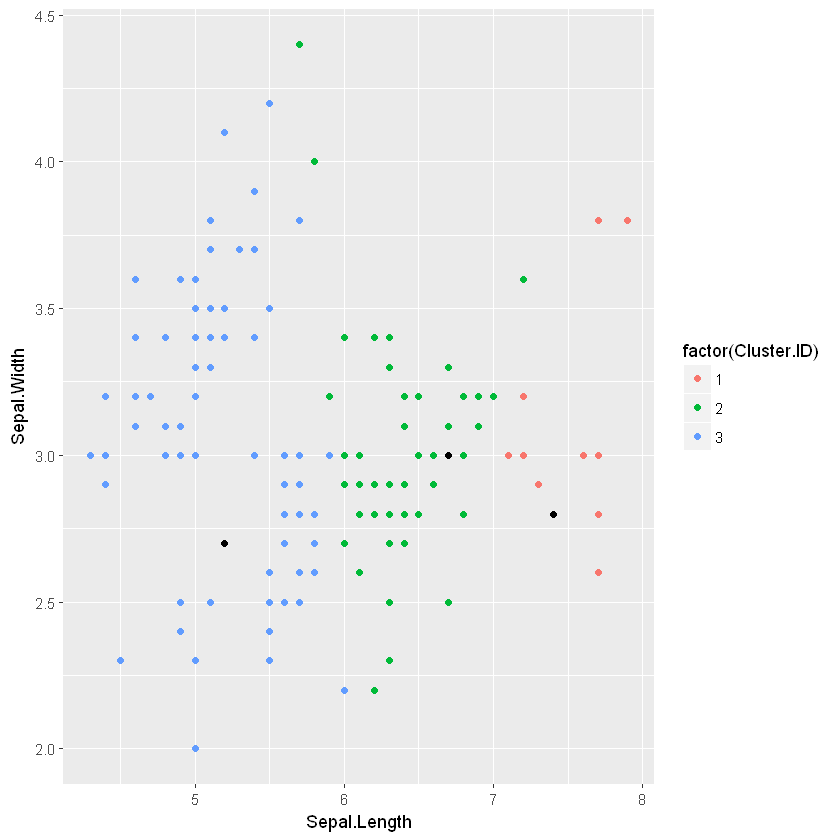

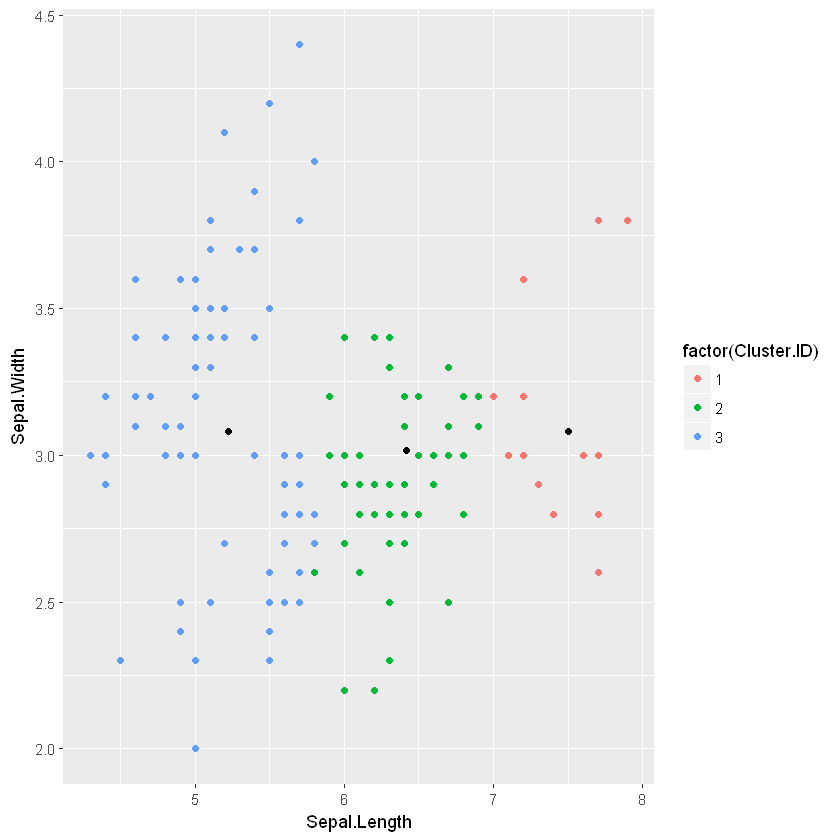

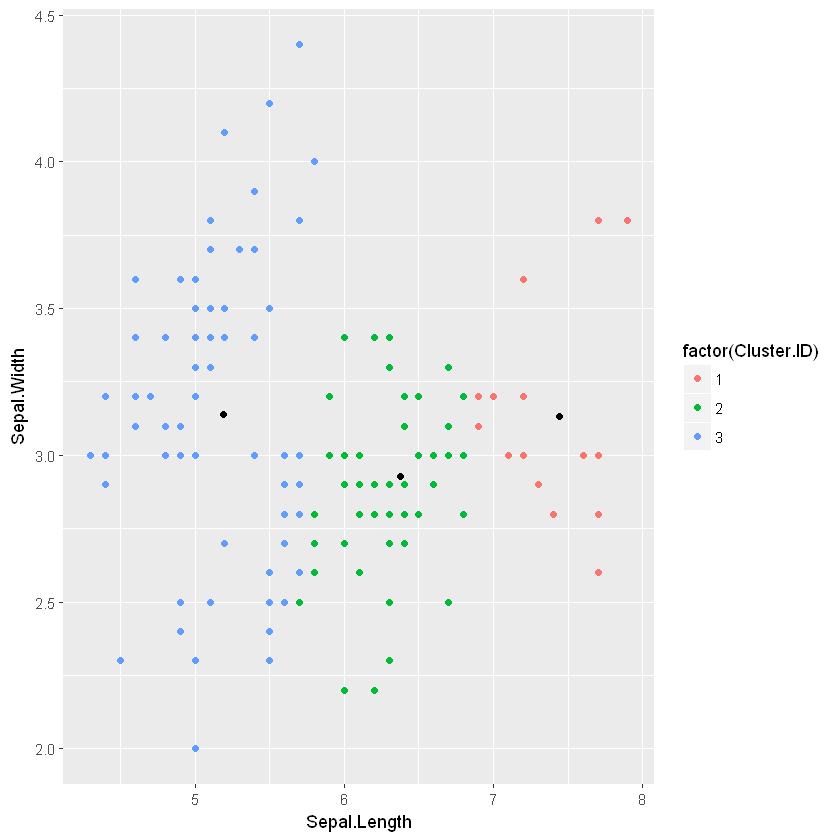

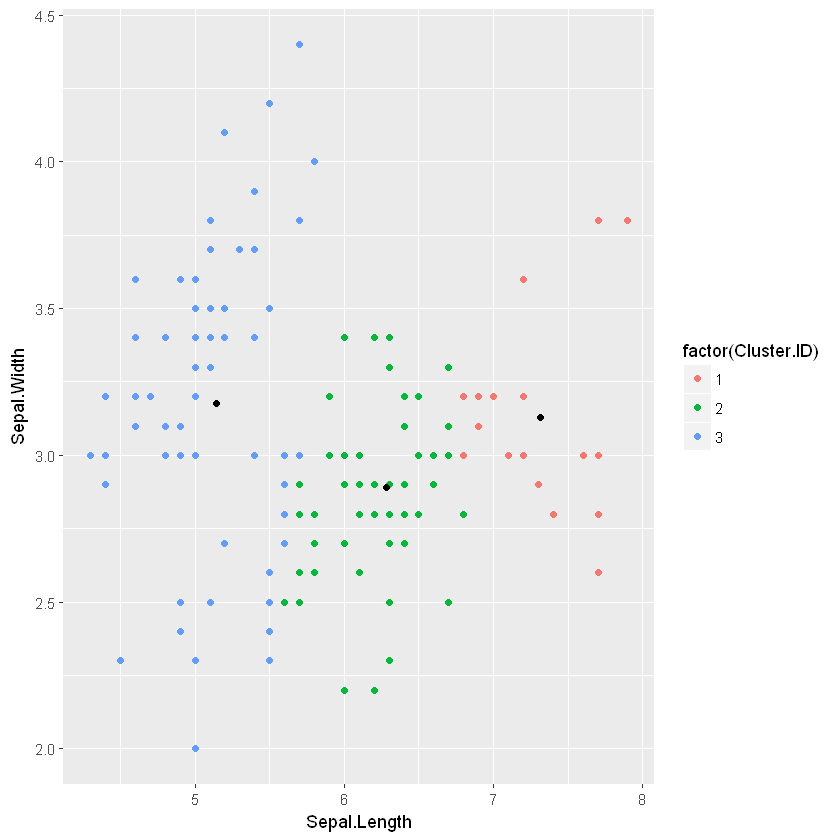

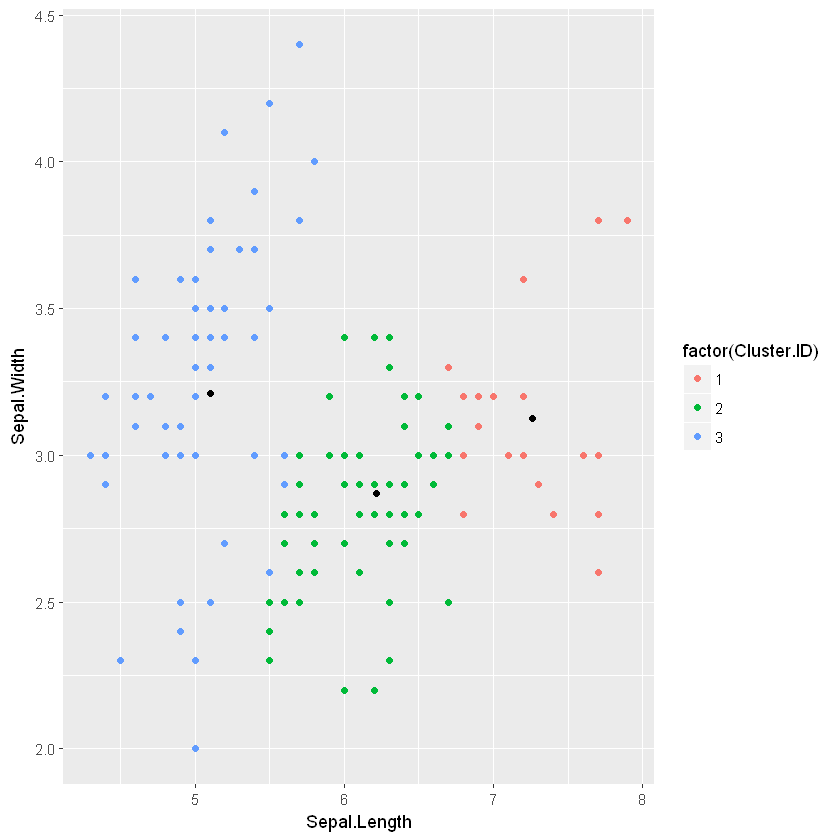

In [758]:
run <- function(dataframe, k, maxIterations){
    results <- kMeans(dataframe, k, maxIterations)
    
    for(i in 1:length(results$dataframe)){
        
        # Here we get our return data from kMeans for each iteration
        getFrame <- results$dataframe[i]
        getCentroids <- results$oldCentroids[i]
        
        # We need to translate our list items back into dataframes
        points <- setNames(do.call(rbind.data.frame, getFrame), c("Sepal.Length","Sepal.Width","Euclidean.Distance","Cluster.ID"))
        centroids <- setNames(do.call(rbind.data.frame, getCentroids), c("Sepal.Length","Sepal.Width"))
        
        # Now we can plot the points
        print(plot(points, centroids))
    }
}

run(data, 3, 5)

## Conclusion

Congratulations; you've completed your first clustering algorithm! Remember, K-Means is used with unlabeled, continuous data, with several (or many) features.

There are lots of cool ways K-Means can be implemented with real world data - namely, for things like identifying disease, cybersecurity, search engines, consumer analysis, and many more. A super interesting application can be found [here](https://www.kaggle.com/drgilermo/3d-kmeans-animation/notebook). 

How can you apply K-Means to your data?

### Bonus

Notice that in our algorithm, we specified how many times we wanted our algorithm to run. It can be cumbersome to try running it 10 times, 20 times, 30, 31, 32... 

Can you think of a way to automatically tell our algorithm how many times it should run? <i>Hint: Another way to think about it is, "When should the algorithm <b>stop</b> running?"</i>

### SciKit-Learn

What you've learned in this workshop is how K-Means works from the ground up. However, after you gain a full understanding of the algorithm and how it works, there's no need to continually re-implement it over and over. R has a [K-Means function](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/kmeans.html) built-in, should you prefer to use a pre-built function. 

### Other Resources

* [Siraj Raval's video on K-Means clustering](https://www.youtube.com/watch?v=9991JlKnFmk&pbjreload=10)
* [Explaining K-Means](http://bigdata-madesimple.com/possibly-the-simplest-way-to-explai n-k-means-algorithm/)
* [Sk-Learn K-Means function on handwritten digits - demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)